In [12]:
fidx = 'ens'
midx = '66'

import numpy as np
import pickle

# class-specific ensemble weights
weights = pickle.load(open('ens_weights66.pkl','rb'))
print(len(weights))

glist = ['air_u67',
           'preresnet_u67','preresnet_u101',
           'resnet_w65'
           ]

glist += ['iv3_q11','irv2_q10','resnet_q24','resnet_q25','resnet_q40',
          'gap_q12','nas_q11','nas_q12','se_resnext_q26','se_resnext_q28',
          'bni_q0','bni_q1']

glist += ['iv3_q12','iv3_u11','iv3_u12','irv2_u12',
           'resnet_q26','resnet_q27',
           'resnet_u25','resnet_u31','resnet_u56',
           'resnet_u60','resnet_u61','resnet_u63',
           'resnet_u65','resnet_u101',
           'se_resnet_u50','se_resnext_u29',
           'gap_u14','bni_u1','bni_u2']


28


In [13]:
# list of unique model names
allm = [weights[i]['mod'].values for i in range(len(weights))]
mnames = list(set().union(*allm))
print(mnames)
print(len(mnames))

['se_resnext_u29', 'preresnet_u101', 'iv3_q12', 'resnet_q26', 'se_resnext_q26', 'resnet_u60', 'gap_q12', 'resnet_q40', 'resnet_u63', 'air_u67', 'bni_q0', 'iv3_u11', 'resnet_u65', 'se_resnext_q28', 'irv2_u12', 'iv3_q11', 'bni_q1', 'bni_u1', 'resnet_u61', 'preresnet_u67', 'irv2_q10', 'nas_q11', 'gap_u14', 'iv3_u12', 'resnet_q27', 'resnet_u25', 'resnet_u56', 'resnet_q25', 'resnet_u31', 'resnet_q24', 'se_resnet_u50', 'resnet_w65', 'bni_u2', 'resnet_u101']
34


In [14]:
nfold = 4
threshold = 0.52
sub_dir = './sub/'

print(fidx,midx,nfold,len(mnames))

ens 66 4 34


In [15]:

blist = ['blend_0459']
tlist = ['iv3_a4','se_resnext_d10','se_resnext_d11']
klist = ['resnet34_46','resnet50','resnet34']
print(glist)
print(blist)
print(tlist)
print(klist)

gpct = 97.5
gscale = 10.

['air_u67', 'preresnet_u67', 'preresnet_u101', 'resnet_w65', 'iv3_q11', 'irv2_q10', 'resnet_q24', 'resnet_q25', 'resnet_q40', 'gap_q12', 'nas_q11', 'nas_q12', 'se_resnext_q26', 'se_resnext_q28', 'bni_q0', 'bni_q1', 'iv3_q12', 'iv3_u11', 'iv3_u12', 'irv2_u12', 'resnet_q26', 'resnet_q27', 'resnet_u25', 'resnet_u31', 'resnet_u56', 'resnet_u60', 'resnet_u61', 'resnet_u63', 'resnet_u65', 'resnet_u101', 'se_resnet_u50', 'se_resnext_u29', 'gap_u14', 'bni_u1', 'bni_u2']
['blend_0459']
['iv3_a4', 'se_resnext_d10', 'se_resnext_d11']
['resnet34_46', 'resnet50', 'resnet34']


In [16]:
import numpy as np
import pandas as pd
import pickle
import os
from os import path
from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage.transform import resize

from scipy.special import logit, expit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import jaccard_similarity_score, f1_score

import scipy.optimize as opt

import gc
import cv2
from tqdm import tqdm_notebook

from numpy import inf

In [17]:
name_label_dict = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}
LABEL_MAP = name_label_dict
np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [18]:
test_df = pd.read_csv("sample_submission.csv", index_col="Id")
print(test_df.head())
print(test_df.shape)

                                      Predicted
Id                                             
00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
(11702, 1)


In [19]:
# test_df["images"] = [np.array(load_img("images/{}.png".format(idx), \
#                                         color_mode = "grayscale")) / 255. \
#                                         # grayscale=True)) / 255. \
#                       for idx in tqdm_notebook(test_df.index)]
# print(test_df.shape)

In [20]:
test_df.columns

Index(['Predicted'], dtype='object')

In [21]:
# save a base copy for reuse below
test_df0 = test_df.copy()


In [22]:
# build submission ensemble as weighted average on logit scale
test_df = test_df0.copy()
idx = test_df.index.values

firstm = True
sumw = 0.

for m in mnames:

    firstf = True
    navg = 0
    if m in blist: suffix = '.npy'
    elif m in klist: suffix = '.pkl'
    else: suffix = '_mm.pkl'
    for fold in range(nfold):
#         print('')
#         print(m+'_'+str(fold))
        first = True
        nr = 0
        for rep in ['','a','b','c','d','e','f','g','h','i']:
            if m in blist:
                fname = sub_dir + m + rep + suffix
                if fold > 0: fname = fname + '_' + str(fold)
            else:
                fname = sub_dir + m + rep + '_' + str(fold) + suffix
            if os.path.exists(fname):
                print()
                print(fname)
                if m in blist:
                    ptestb = np.load(fname)
                    idb = idb0
                elif m in klist: 
                    idb, ptestb = pickle.load(open(fname,'rb'))
                    # ptestb = logit(ptestb)
                elif m in tlist:
                    idb, ptestba, ptestb, ptestbb = pickle.load(open(fname,'rb'))
                    ptestb = expit(ptestb)
                elif m in glist:
                    idb, ptestb, ptestba = pickle.load(open(fname,'rb'))
                    ptestb = np.percentile(ptestb, gpct, axis=(2,3))
                    ptestb = 1./(1. + np.exp(-ptestb/gscale))
                else:
                    idb, ptestb, ptestba = pickle.load(open(fname,'rb'))
                    ptestb = expit(ptestb)
                
                # ptestb = np.clip(ptestb,-20.0,20.0)
                # ptestb[ptestb==-inf] = -6.0
                # ptestb[ptestb==inf] = 6.0
                
                print(ptestb.min(),ptestb.mean(),ptestb.max())
                
                if first:
                    ptestf = ptestb.copy()
                    idb0 = idb
                    first = False
                else:
                    checki = [i0 != i1 for i0,i1 in zip(idb0,idb)]
                    si = np.array(checki).sum()
                    # print(si)
                    assert si == 0
                    print(np.corrcoef(np.array(ptestf).flatten(),
                                      np.array(ptestb).flatten()))

                    ptestf += ptestb
                nr += 1
                
        if nr > 0:
            ptestf /= nr
            print(ptestf.shape,ptestf.min(),ptestf.mean(),ptestf.max())

            if firstf:
                id = idb
                ptest = ptestf.copy()
                firstf = False
            else:
                print(np.corrcoef(np.array(ptest).flatten(),
                                  np.array(ptestf).flatten()))
                ptest += ptestf
                
            navg += 1
    
    if navg != nfold: raise ValueError('Found %d folds for %s instead of %d' % (navg,m,nfold))
    ptest /= navg
    pmask = (ptest > threshold).astype(int)
    print(m,navg,ptest.shape,ptest.min(),ptest.mean(),ptest.max(),pmask.mean())
    td = pd.DataFrame({'id':id})
    td[m] = [a for a in ptest]
    td.set_index('id',inplace=True)
    test_df = test_df.join(td)



./sub/se_resnext_u29_0_mm.pkl
0.15442735423910817 0.3755387730470465 0.7375212787901021
(11702, 28) 0.15442735423910817 0.3755387730470465 0.7375212787901021

./sub/se_resnext_u29_1_mm.pkl
0.16853313984436605 0.3827815465656677 0.7537612412800868
(11702, 28) 0.16853313984436605 0.3827815465656677 0.7537612412800868
[[1.  0.9]
 [0.9 1. ]]

./sub/se_resnext_u29_2_mm.pkl
0.1543365685218717 0.3825616589971956 0.806602931260397
(11702, 28) 0.1543365685218717 0.3825616589971956 0.806602931260397
[[1.    0.923]
 [0.923 1.   ]]

./sub/se_resnext_u29_3_mm.pkl
0.18021483079791809 0.3949150327450768 0.7319149442048672
(11702, 28) 0.18021483079791809 0.3949150327450768 0.7319149442048672
[[1.    0.921]
 [0.921 1.   ]]
se_resnext_u29 4 (11702, 28) 0.1958549389881013 0.38394925283874665 0.7024622475823459 0.05987987401421003

./sub/preresnet_u101_0_mm.pkl
0.11920292202211755 0.3790204213261964 0.82252363490726
(11702, 28) 0.11920292202211755 0.3790204213261964 0.82252363490726

./sub/preresnet_u101

In [23]:
test_df.columns

Index(['Predicted', 'se_resnext_u29', 'preresnet_u101', 'iv3_q12',
       'resnet_q26', 'se_resnext_q26', 'resnet_u60', 'gap_q12', 'resnet_q40',
       'resnet_u63', 'air_u67', 'bni_q0', 'iv3_u11', 'resnet_u65',
       'se_resnext_q28', 'irv2_u12', 'iv3_q11', 'bni_q1', 'bni_u1',
       'resnet_u61', 'preresnet_u67', 'irv2_q10', 'nas_q11', 'gap_u14',
       'iv3_u12', 'resnet_q27', 'resnet_u25', 'resnet_u56', 'resnet_q25',
       'resnet_u31', 'resnet_q24', 'se_resnet_u50', 'resnet_w65', 'bni_u2',
       'resnet_u101'],
      dtype='object')

In [24]:
print(idx[:5])

['00008af0-bad0-11e8-b2b8-ac1f6b6435d0' '0000a892-bacf-11e8-b2b8-ac1f6b6435d0'
 '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0' '0008baca-bad7-11e8-b2b9-ac1f6b6435d0'
 '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0']


In [25]:
f = []
clist = list(test_df.columns[1:])
for c in clist:
    ff = np.array(list(test_df[c])).flatten()
    print(ff.shape,c)
    f.append(ff)
# print(clist)
r = np.corrcoef(f)
print(r)

(327656,) se_resnext_u29
(327656,) preresnet_u101
(327656,) iv3_q12
(327656,) resnet_q26
(327656,) se_resnext_q26
(327656,) resnet_u60
(327656,) gap_q12
(327656,) resnet_q40
(327656,) resnet_u63
(327656,) air_u67
(327656,) bni_q0
(327656,) iv3_u11
(327656,) resnet_u65
(327656,) se_resnext_q28
(327656,) irv2_u12
(327656,) iv3_q11
(327656,) bni_q1
(327656,) bni_u1
(327656,) resnet_u61
(327656,) preresnet_u67
(327656,) irv2_q10
(327656,) nas_q11
(327656,) gap_u14
(327656,) iv3_u12
(327656,) resnet_q27
(327656,) resnet_u25
(327656,) resnet_u56
(327656,) resnet_q25
(327656,) resnet_u31
(327656,) resnet_q24
(327656,) se_resnet_u50
(327656,) resnet_w65
(327656,) bni_u2
(327656,) resnet_u101
[[1.    0.933 0.899 ... 0.919 0.918 0.925]
 [0.933 1.    0.895 ... 0.957 0.934 0.944]
 [0.899 0.895 1.    ... 0.886 0.907 0.914]
 ...
 [0.919 0.957 0.886 ... 1.    0.932 0.942]
 [0.918 0.934 0.907 ... 0.932 1.    0.956]
 [0.925 0.944 0.914 ... 0.942 0.956 1.   ]]


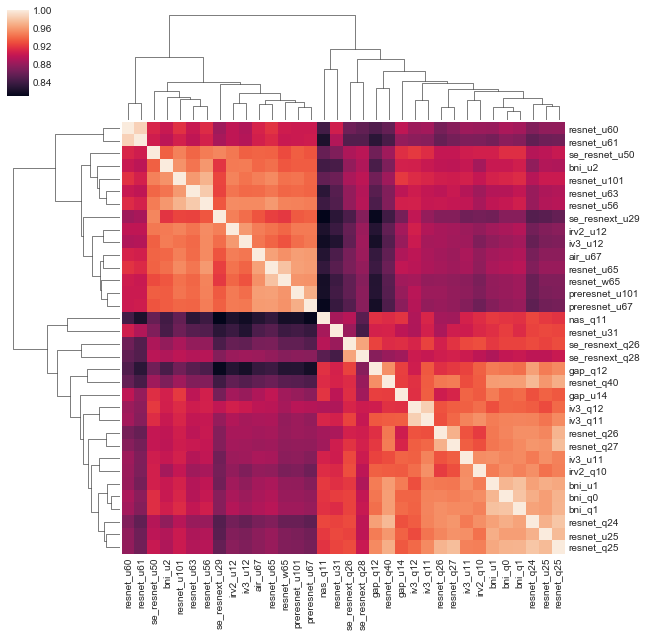

In [26]:
d = pd.DataFrame(r, columns=mnames)
d['id'] = mnames
d.set_index('id',inplace=True)
del d.index.name

sns.clustermap(d)


# import scipy.cluster.hierarchy as hc
# from matplotlib import pyplot
# link = hc.linkage(d.values, method='centroid')
# o1 = hc.leaves_list(link)

# mat = d.iloc[o1,:]
# mat = mat.iloc[:, o1[::-1]]
# pyplot.imshow(mat)

In [27]:
flat = np.transpose(np.array(f))
print(flat.shape)
fname = 'flat.csv'
fdf = pd.DataFrame(flat)
fdf.columns = clist
fdf.to_csv(fname)
print(fname)

(327656, 34)
flat.csv


In [28]:
ens = np.zeros((test_df.shape[0],28))

# apply class-specific ensemble weights
for i in range(28):

    f = []
    clist = weights[i]['mod'].values
    for c in clist:
        f.append(np.array(list(test_df[c])))
    m = np.array(f)
    print(m.shape)

    w = np.array(weights[i]['weight'].values)
    print(i, clist, w)

    ens[:,i] = np.average(m,axis=0,weights=w)[:,i]
    
print(ens.shape)

(9, 11702, 28)
0 ['air_u67' 'preresnet_u67' 'preresnet_u101' 'resnet_w65' 'se_resnext_u29' 'resnet_q27' 'resnet_u60'
 'se_resnet_u50' 'bni_u2'] [3 2 4 1 5 6 2 2 1]
(6, 11702, 28)
1 ['resnet_w65' 'se_resnext_u29' 'bni_q0' 'iv3_u11' 'iv3_u12' 'resnet_u63'] [1 4 1 2 1 3]
(10, 11702, 28)
2 ['air_u67' 'preresnet_u67' 'preresnet_u101' 'resnet_w65' 'irv2_q10' 'resnet_q40' 'resnet_q27'
 'resnet_u25' 'resnet_u31' 'resnet_u65'] [6 1 1 9 1 2 4 1 1 1]
(9, 11702, 28)
3 ['air_u67' 'preresnet_u67' 'preresnet_u101' 'resnet_w65' 'se_resnext_u29' 'nas_q11' 'irv2_u12'
 'resnet_q27' 'resnet_u61'] [1 1 3 6 4 1 3 1 4]
(10, 11702, 28)
4 ['air_u67' 'preresnet_u67' 'resnet_w65' 'se_resnext_u29' 'resnet_u25' 'resnet_u31' 'resnet_u56'
 'resnet_u60' 'resnet_u61' 'resnet_u63'] [4 4 2 6 2 1 1 1 3 5]
(12, 11702, 28)
5 ['air_u67' 'preresnet_u101' 'resnet_w65' 'se_resnext_u29' 'resnet_q26' 'resnet_q27' 'resnet_u25'
 'resnet_u31' 'resnet_u60' 'resnet_u61' 'se_resnet_u50' 'gap_u14'] [4 4 4 3 1 2 1 1 3 4 1 1]
(9, 11702, 

In [29]:
print(ens[1])

[0.482 0.378 0.435 0.424 0.429 0.612 0.475 0.415 0.29  0.303 0.284 0.435 0.406 0.386 0.41  0.311
 0.423 0.399 0.462 0.446 0.344 0.453 0.4   0.422 0.425 0.537 0.427 0.33 ]


In [30]:
# fname = 'mthresh.pkl'
# if os.path.isfile(fname): mthresh = pickle.load(open(fname,'rb'))
# mthresh[mname]

In [31]:
# desired class proportions from lb probing

desired = {
0 : 0.36239782,
1 : 0.043841336,
2 : 0.075268817,
3 : 0.059322034,
4 : 0.075268817,
5 : 0.075268817,
6 : 0.043841336,
7 : 0.075268817,
8 : 0.0018,
9 : 0.0014,
10 : 0.0009,
11 : 0.043841336,
12 : 0.043841336,
13 : 0.014198783,
14 : 0.043841336,
15 : 0.0007,
16 : 0.028806584,
17 : 0.014198783,
18 : 0.028806584,
19 : 0.059322034,
20 : 0.0056,
21 : 0.126126126,
22 : 0.028806584,
23 : 0.075268817,
24 : 0.0104,
25 : 0.222493888,
26 : 0.028806584,
27 : 0.0004
}
print(desired)

{0: 0.36239782, 1: 0.043841336, 2: 0.075268817, 3: 0.059322034, 4: 0.075268817, 5: 0.075268817, 6: 0.043841336, 7: 0.075268817, 8: 0.0018, 9: 0.0014, 10: 0.0009, 11: 0.043841336, 12: 0.043841336, 13: 0.014198783, 14: 0.043841336, 15: 0.0007, 16: 0.028806584, 17: 0.014198783, 18: 0.028806584, 19: 0.059322034, 20: 0.0056, 21: 0.126126126, 22: 0.028806584, 23: 0.075268817, 24: 0.0104, 25: 0.222493888, 26: 0.028806584, 27: 0.0004}


In [32]:
# fixed global threshold
pred = (ens > threshold).astype(int)
print('fixed threshold',threshold)
for j in range(pred.shape[1]):
    prop = np.mean(pred[:,j])
    print(j,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j],)

fixed threshold 0.52
0 0.3624 0.5414 Nucleoplasm
1 0.0438 0.0422 Nuclear membrane
2 0.0753 0.1031 Nucleoli
3 0.0593 0.0378 Nucleoli fibrillar center
4 0.0753 0.0422 Nuclear speckles
5 0.0753 0.0559 Nuclear bodies
6 0.0438 0.0283 Endoplasmic reticulum
7 0.0753 0.0679 Golgi apparatus
8 0.0018 0.0003 Peroxisomes
9 0.0014 0.0011 Endosomes
10 0.0009 0.0003 Lysosomes
11 0.0438 0.0384 Intermediate filaments
12 0.0438 0.0261 Actin filaments
13 0.0142 0.0146 Focal adhesion sites
14 0.0438 0.0532 Microtubules
15 0.0007 0.0003 Microtubule ends
16 0.0288 0.0236 Cytokinetic bridge
17 0.0142 0.0251 Mitotic spindle
18 0.0288 0.0423 Microtubule organizing center
19 0.0593 0.0549 Centrosome
20 0.0056 0.0026 Lipid droplets
21 0.1261 0.1987 Plasma membrane
22 0.0288 0.0244 Cell junctions
23 0.0753 0.0795 Mitochondria
24 0.0104 0.0104 Aggresome
25 0.2225 0.4785 Cytosol
26 0.0288 0.0100 Cytoplasmic bodies
27 0.0004 0.0005 Rods & rings


In [33]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]

from scipy.special import expit

def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

pred_t = expit(ens)
th_t = fit_test(pred_t,lb_prob)
th_t[th_t<0.1] = 0.1
np.set_printoptions(precision=3, suppress=True, linewidth=100)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))
pred = (pred_t > th_t).astype(int)

Thresholds:  [0.641 1.306 0.665 1.218 1.202 0.662 1.179 0.662 1.178 1.141 0.659 1.186 1.338 1.417 1.385 1.079
 1.125 1.332 1.092 0.666 1.372 0.657 1.267 1.033 1.399 0.652 1.407 1.314]
Fractions:  [0.251 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
Fractions (th = 0.5):  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [78]:
ens.shape

(11702, 28)

In [84]:
p = pd.DataFrame(ens)
p.columns = ['p'+str(i) for i in range(ens.shape[1])]
subp = pd.DataFrame({'id':ids,'data':'sub'})
subp = pd.concat((subp,p),axis=1)
print(subp.shape)
fname = 'sub/sub' + midx + '_probs.csv'
subp.to_csv(fname, index=False)
print(fname)

(11702, 30)
sub/sub66_probs.csv


In [34]:
# custom thresholds to match lb proportions
thresholds = np.linspace(0.9, 0.1, 100001)
pred = ens.copy()
th = []
for j in range(pred.shape[1]):
    for t in thresholds:
        pred[:,j] = (ens[:,j] > t).astype(int)
        prop = np.mean(pred[:,j])
        if prop >= desired[j]: break
    th.append(t)
    print(j,'%6.4f' % t,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j])

0 0.5588 0.3624 0.3624 Nucleoplasm
1 0.5156 0.0438 0.0439 Nuclear membrane
2 0.5456 0.0753 0.0753 Nucleoli
3 0.4839 0.0593 0.0594 Nucleoli fibrillar center
4 0.4745 0.0753 0.0753 Nuclear speckles
5 0.5073 0.0753 0.0753 Nuclear bodies
6 0.5009 0.0438 0.0439 Endoplasmic reticulum
7 0.5129 0.0753 0.0753 Golgi apparatus
8 0.4123 0.0018 0.0019 Peroxisomes
9 0.4868 0.0014 0.0015 Endosomes
10 0.4506 0.0009 0.0009 Lysosomes
11 0.5107 0.0438 0.0439 Intermediate filaments
12 0.4809 0.0438 0.0439 Actin filaments
13 0.5237 0.0142 0.0143 Focal adhesion sites
14 0.5485 0.0438 0.0439 Microtubules
15 0.4536 0.0007 0.0008 Microtubule ends
16 0.5147 0.0288 0.0289 Cytokinetic bridge
17 0.5376 0.0142 0.0143 Mitotic spindle
18 0.5325 0.0288 0.0289 Microtubule organizing center
19 0.5167 0.0593 0.0594 Centrosome
20 0.4764 0.0056 0.0056 Lipid droplets
21 0.5400 0.1261 0.1261 Plasma membrane
22 0.5094 0.0288 0.0289 Cell junctions
23 0.5235 0.0753 0.0754 Mitochondria
24 0.5202 0.0104 0.0104 Aggresome
25 0.5552

In [35]:
# # linear adjustment of thresholds estimated in ens_oof.ipynb
# for j in range(pred.shape[1]):
#     t = 0.094 + 0.827*th[j]
#     pred[:,j] = (ens[:,j] > t).astype(int)
#     prop = np.mean(pred[:,j])
#     print(j,'%6.4f' % t,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j])

In [36]:
np.set_printoptions(linewidth=100)
print(pred[:5].astype(int))

[[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [37]:
xps = np.sum(pred,axis=1)
print(xps.shape)
print(xps.min(),xps.mean(),xps.max())

(11702,)
0.0 1.591608272090241 5.0


In [38]:
print(sum(xps==0)/pred.shape[0])

0.06793710476841565


In [39]:
subs = []
ids = []
for i,fid in enumerate(test_df.index.values):
    subrow = ' '.join(list([str(i) for i in np.nonzero(pred[i])[0]]))
    subs.append(subrow)
    ids.append(fid)
    if i % 1000 == 0: print(i,fid,subrow)
print({'ids':ids[:10], 'subs':subs[:10]})
print(len(ids), len(subs))

0 00008af0-bad0-11e8-b2b8-ac1f6b6435d0 2
1000 15efe29e-bad4-11e8-b2b8-ac1f6b6435d0 26
2000 2bd51caa-bad9-11e8-b2b9-ac1f6b6435d0 24
3000 42f7f174-bace-11e8-b2b8-ac1f6b6435d0 0
4000 589b3070-bad0-11e8-b2b8-ac1f6b6435d0 3
5000 6dd7e7b6-bac7-11e8-b2b7-ac1f6b6435d0 25
6000 835f7a30-bad7-11e8-b2b9-ac1f6b6435d0 2 3 23
7000 9932fa46-bac6-11e8-b2b7-ac1f6b6435d0 21 25
8000 aeabe93c-bacb-11e8-b2b8-ac1f6b6435d0 1
9000 c4ad1a3a-bada-11e8-b2b9-ac1f6b6435d0 11
10000 da851aec-bada-11e8-b2b9-ac1f6b6435d0 0 21 25
11000 f071ee12-bad9-11e8-b2b9-ac1f6b6435d0 21
{'ids': ['00008af0-bad0-11e8-b2b8-ac1f6b6435d0', '0000a892-bacf-11e8-b2b8-ac1f6b6435d0', '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0', '0008baca-bad7-11e8-b2b9-ac1f6b6435d0', '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0', '00109f6a-bac8-11e8-b2b7-ac1f6b6435d0', '001765de-bacd-11e8-b2b8-ac1f6b6435d0', '0018641a-bac9-11e8-b2b8-ac1f6b6435d0', '00200f22-bad7-11e8-b2b9-ac1f6b6435d0', '0026f154-bac6-11e8-b2b7-ac1f6b6435d0'], 'subs': ['2', '5', '0 5 25', '0', '', '4', 

In [40]:
subm = pd.DataFrame.from_dict({'Id':ids, 'Predicted':subs}, orient='index').T
fname = 'sub/' + fidx + midx + '.csv'
subm.to_csv(fname, index=False)
print(fname)

sub/ens66.csv


In [41]:
from itertools import chain
from collections import Counter
max_idx = 27
subm['target_list'] = subm['Predicted'].map(lambda x: \
            [int(a) if a != '' else -1 for a in str(x).split(' ')])
subm['target_vec'] = subm['target_list'].map(lambda ck: \
            [i in ck for i in range(max_idx+1)])
all_labels = list(chain.from_iterable(subm['target_list'].values))
c_val = Counter(all_labels)
n_keys = c_val.keys()
max_idx = max(n_keys)
for k,v in name_label_dict.items():
    print(k,v, 'count', c_val[k] if k in c_val else 0,
             'prop', '%6.4f' % (c_val[k]/len(ids) if k in c_val else 0))

0 Nucleoplasm count 4241 prop 0.3624
1 Nuclear membrane count 514 prop 0.0439
2 Nucleoli count 881 prop 0.0753
3 Nucleoli fibrillar center count 695 prop 0.0594
4 Nuclear speckles count 881 prop 0.0753
5 Nuclear bodies count 881 prop 0.0753
6 Endoplasmic reticulum count 514 prop 0.0439
7 Golgi apparatus count 881 prop 0.0753
8 Peroxisomes count 22 prop 0.0019
9 Endosomes count 17 prop 0.0015
10 Lysosomes count 11 prop 0.0009
11 Intermediate filaments count 514 prop 0.0439
12 Actin filaments count 514 prop 0.0439
13 Focal adhesion sites count 167 prop 0.0143
14 Microtubules count 514 prop 0.0439
15 Microtubule ends count 9 prop 0.0008
16 Cytokinetic bridge count 338 prop 0.0289
17 Mitotic spindle count 167 prop 0.0143
18 Microtubule organizing center count 338 prop 0.0289
19 Centrosome count 695 prop 0.0594
20 Lipid droplets count 66 prop 0.0056
21 Plasma membrane count 1476 prop 0.1261
22 Cell junctions count 338 prop 0.0289
23 Mitochondria count 882 prop 0.0754
24 Aggresome count 122 

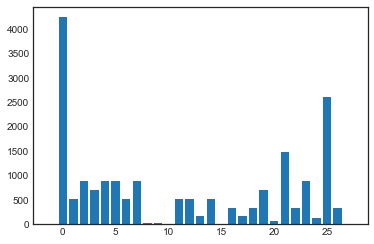

In [42]:
train_sum_vec = np.sum(np.stack(subm['target_vec'].values, 0), 0)
_ = plt.bar(n_keys, [train_sum_vec[k] for k in n_keys])

In [43]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


# computute confusion matrices between two submission files
def f1_confusion(csv0, csv1, num_classes=28):
    c0 = pd.read_csv(csv0)
    c1 = pd.read_csv(csv1)
    assert c0.shape == c1.shape
    s0 = [s if isinstance(s,str) else '' for s in c0.Predicted]
    s1 = [s if isinstance(s,str) else '' for s in c1.Predicted]
    p0 = [s.split() for s in s0]
    p1 = [s.split() for s in s1]
    y0 = np.zeros((c0.shape[0],num_classes)).astype(int)
    y1 = np.zeros((c0.shape[0],num_classes)).astype(int)
    # print(p0[:5])
    for i in range(c0.shape[0]):
        for j in p0[i]: y0[i,int(j)] = 1
        for j in p1[i]: y1[i,int(j)] = 1
    # print(y0[:5])
    
    y0avg = np.average(y0,axis=0)
    y1avg = np.average(y1,axis=0)
    cm = [confusion_matrix(y0[:,i], y1[:,i]) for i in range(y0.shape[1])]
    fm = [f1_score(y0[:,i], y1[:,i]) for i in range(y0.shape[1])]
    for i in range(y0.shape[1]):
        print(LABEL_MAP[i])
        print(cm[i],' %4.2f' % fm[i],' %6.4f' % y0avg[i],' %6.4f' % y1avg[i],
             ' %6.4f' % (y0avg[i] - y1avg[i]))
        print()
#     print('y0avg')
#     print(y0avg)
#     print('y1avg')
#     print(y1avg)
#     print('y0avg - y1avg')
#     print(y0avg-y1avg)
    print('f1 macro')
    print(np.mean(fm))       
    return f1_score(y0, y1, average='macro')
    
# compute f1 score between two submission files
def f1_sub(csv0, csv1, num_classes=28):
    c0 = pd.read_csv(csv0)
    c1 = pd.read_csv(csv1)
    assert c0.shape == c1.shape
    s0 = [s if isinstance(s,str) else '' for s in c0.Predicted]
    s1 = [s if isinstance(s,str) else '' for s in c1.Predicted]
    p0 = [s.split() for s in s0]
    p1 = [s.split() for s in s1]
    y0 = np.zeros((c0.shape[0],num_classes)).astype(int)
    y1 = np.zeros((c0.shape[0],num_classes)).astype(int)
    # print(p0[:5])
    for i in range(c0.shape[0]):
        for j in p0[i]: y0[i,int(j)] = 1
        for j in p1[i]: y1[i,int(j)] = 1
    # print(y0[:5])
            
    return f1_score(y0, y1, average='macro')

In [44]:
f1_sub(fname,'sub/ens45.csv')

0.7723535133931935

In [45]:
f1_sub(fname,'sub/ens46.csv')

0.7563322216924018

In [46]:
f1_sub(fname,'sub/ens47.csv')

0.7633232623323897

In [47]:
f1_sub(fname,'sub/ens48.csv')

0.7598744360912645

In [48]:
f1_sub(fname,'sub/ens49.csv')

0.7655458049915619

In [49]:
f1_sub(fname,'sub/ens53.csv')

0.8769491992448033

In [50]:
f1_sub(fname,'sub/ens53c.csv')

0.8682942935660438

In [51]:
f1_sub(fname,'sub/ens53d.csv')

0.8680247629971394

In [52]:
f1_sub(fname,'sub/ens55.csv')

0.873470977825163

In [53]:
f1_sub(fname,'sub/ens55d.csv')

0.8693557452691886

In [54]:
f1_sub(fname,'sub/ens56.csv')

0.8854163554483073

In [55]:
f1_sub(fname,'sub/ens56d.csv')

0.8758395069031598

In [56]:
f1_sub(fname,'sub/ens58.csv')

0.9020952050735059

In [57]:
f1_sub(fname,'sub/ens58d.csv')

0.8928661239075945

In [58]:
f1_sub(fname,'sub/ens59.csv')

0.9006214329294103

In [59]:
f1_sub(fname,'sub/ens59d.csv')

0.8997686708713644

In [60]:
f1_sub(fname,'sub/ens60d.csv')

0.900223384570973

In [61]:
f1_sub(fname,'sub/ens61.csv')

0.9149567667039082

In [76]:
f1_sub(fname,'sub/ens61d.csv')

0.9054273190336825

In [77]:
f1_sub(fname,'sub/ens62.csv')

0.9378171384646395

In [62]:
f1_sub(fname,'sub/preresnet0.csv')

0.8454453832962915

In [63]:
f1_sub(fname,'sub/preresnet0d.csv')

0.8410908268178418

In [64]:
f1_sub(fname,'sub/resnet11.csv')

0.6840656397195645

In [65]:
f1_sub(fname,'sub/resnet12.csv')

0.7159431388185306

In [66]:
f1_sub(fname,'sub/resnet13.csv')

0.7204988913216861

In [67]:
f1_sub(fname,'sub/resnet15.csv')

0.8304270744659219

In [68]:
f1_sub(fname,'sub/resnet15c.csv')

0.8214235829241151

In [69]:
f1_sub(fname,'sub/resnet16.csv')

0.6969980518242858

In [70]:
f1_sub(fname,'sub/resnet17.csv')

0.836040005408817

In [71]:
f1_sub(fname,'sub/resnet17.csv')

0.836040005408817

In [72]:
f1_sub(fname,'sub/se_resnext11.csv')

0.8034006605437723

In [73]:
f1_sub(fname,'sub/se_resnext11d.csv')

0.8035261321475335

In [74]:
print(fname)

sub/ens66.csv


In [75]:
# f1_confusion(fname, 'sub/ens56.csv')